**Introduction**

- Overview of CORAL

    CORrelation ALignment (CORAL) loss is a technique used in domain adaptation to align the second-order statistics (covariances) of the source and target domain features. The goal is to reduce the domain shift by matching the covariance matrices of the two domains.

- Importance of CORAL
    You need a simple and efficient alignment technique.You want to integrate alignment into deep learning models easily, then it would be with other alignment techniques like MMD (Maximum Mean Discrepancy)

- Semi-Supervised Learning
    In a semi-supervised setting, you have a mixture of labeled and unlabeled data in the target domain.

- Applications of Coral in SSDA
    This scenario is quite common as it benefits from both the alignment of feature distributions and the utilization of limited labeled target data to enhance adaptation.

Prerequisites

*   Basic knowledge of PyTorch
*   Understanding of domain adaptation concepts
*   Understanding the importance of Semi-supervised training



In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.datasets import SVHN, MNIST

In [2]:
# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Data Preparation**

In this tutorial, SVHN will be our target domain and MNIST will be our source domain




*   SVHN (Real-World Dataset):
    Contains real-world images of house numbers,     
    making it a challenging and practical dataset.

*   MNIST
    Contains grayscale images of handwritten digits, providing a controlled environment for experimentation.


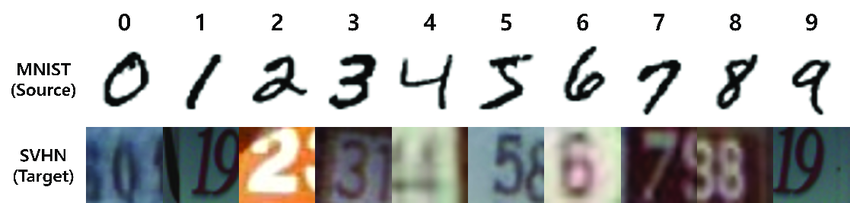

In [3]:
# Data augmentation for MNIST
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1-channel to 3-channel
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.RandomGrayscale(p=0.1)
])

# Data augmentation for SVHN
transform_svhn = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.RandomGrayscale(p=0.1)
])


In [4]:
# Datasets
source_data = MNIST(root='./data', train=True, download=True, transform=transform_mnist)

target_dataset_train = SVHN(root='./data', split='train', transform=transform_svhn, download=True)
target_dataset_test = SVHN(root='./data', split='test', transform=transform_svhn, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.23MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 182M/182M [01:01<00:00, 2.98MB/s]


100%|██████████| 64.3M/64.3M [00:23<00:00, 2.77MB/s]


In [5]:
len(source_data), len(target_dataset_train), len(target_dataset_test)

(60000, 73257, 26032)

Turn your target_dataset_train Dataset into a semi-supervised Dataset, you can create a custom dataset class that handles both labeled and unlabeled data.

In [6]:
class SemiSupervisedDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset

    def __len__(self):
        return len(self.labeled_dataset) + len(self.unlabeled_dataset)

    def __getitem__(self, index):
      if index < len(self.labeled_dataset):
        image, label = self.labeled_dataset[index]
        return image, label
      else:
        image = self.unlabeled_dataset[index - len(self.labeled_dataset)]
        return image, -1


In [7]:
# Simulate unlabeled data by ignoring the labels for a portion of the dataset
num_labeled = 1000  # Number of labeled samples
labeled_data = [(image, label) for image, label in zip(target_dataset_train.data[:num_labeled], target_dataset_train.labels[:num_labeled])]
unlabeled_data = [image for image in target_dataset_train.data[num_labeled:]]

In [8]:
len(labeled_data), len(unlabeled_data)

(1000, 72257)

In [9]:
semi_supervised_dataset_trian = SemiSupervisedDataset(labeled_data, unlabeled_data)

In [10]:
len(semi_supervised_dataset_trian)

73257

In [11]:
# DataLoaders
mnist_loader_source = DataLoader(source_data, batch_size=64, shuffle=True)
svhn_train_loader_target = DataLoader(semi_supervised_dataset_trian, batch_size=64, shuffle=True)
svhn_test_loader_target = DataLoader(target_dataset_test, batch_size=64, shuffle=False)

In [12]:
# Example usage in training
for batch in svhn_train_loader_target:
    data, label = batch
    # Your training code here

**CORAL Alignment:**

A CORAL loss term is added to the overall loss function of the model. This loss term measures the difference between the source and target covariance matrices. The model is trained to minimize this loss, encouraging the feature distributions to align.

In [13]:
def coral_loss(source, target):
  # Compute the covarience matrix
  source_cov = torch.mm(source.t(), source) / (source.size(0) - 1)
  target_cov = torch.mm(target.t(), target) / (target.size(0) - 1)

   # Compute the Frobenius norm of the difference between the covariance matrices
  loss = torch.norm(source_cov - target_cov, p='fro')
  return loss

**Feature Extraction**

By integrating CORAL with a feature extractor like ResNet, you can effectively align the feature distributions of the source and target domains, improving the model's performance on the target domain.

In [14]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = models.resnet50(pretrained=True)
    self.resnet.fc = nn.Identity() # Remove the final fc layer

  def forward(self, x):
    return self.resnet(x)

class Classifier(nn.Module):
  def __init__(self, num_classes, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.feature_extractor = FeatureExtractor()
    self.dropout = nn.Dropout(p=0.5)
    self.classifier = nn.Linear(2048, num_classes)

  def forward(self, x):
    features = self.feature_extractor(x)
    features = self.dropout(features)
    logits = self.classifier(features)
    return logits


**Train Loop**

In [15]:
num_classes = 10

feature_extractor = FeatureExtractor().to(device)
classifier = Classifier(num_classes).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
coral_weight = 0.1  # Weighting factor for CORAL loss

for epoch in range(num_epochs):
  classifier.train()
  total_loss = 0.0

  mnist_iter = iter(mnist_loader_source)
  svhn_iter = iter(svhn_train_loader_target)

  for _ in range(len(mnist_loader_source)):
    source_batch = next(mnist_iter)
    target_batch = next(svhn_iter)


    source_data, source_labels = source_batch
    target_data, _ = target_batch

    source_data, source_labels = source_data.to(device), source_labels.to(device)
    target_data = target_data.to(device)


    # Convert the target_data to Float type
    target_data = target_data.float()

    # Forward pass for source data
    source_logits = classifier(source_data)
    classifier_loss = criterion(source_logits, source_labels)

    # Forward pass for target data
    with torch.no_grad():
      target_features = feature_extractor(target_data)

    # Compute CORAL loss
    source_features = feature_extractor(source_data)
    coral_loss_value = coral_loss(source_features, target_features)

    # Combine losses
    loss = classifier_loss + coral_loss_value * coral_weight

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(mnist_loader_source):.4f}")

print("Training completed!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Epoch [1/10], Loss: 24.0228
Epoch [2/10], Loss: 22.7188
Epoch [3/10], Loss: 21.9677
Epoch [4/10], Loss: 21.7873
Epoch [5/10], Loss: 21.6782
Epoch [6/10], Loss: 21.6349
Epoch [7/10], Loss: 21.5714
Epoch [8/10], Loss: 21.5213
Epoch [9/10], Loss: 21.5245
Epoch [10/10], Loss: 21.5101
Training completed!


In [19]:
# Epoch [1/10], Loss: 24.0228
# Epoch [2/10], Loss: 22.7188
# Epoch [3/10], Loss: 21.9677
# Epoch [4/10], Loss: 21.7873
# Epoch [5/10], Loss: 21.6782
# Epoch [6/10], Loss: 21.6349
# Epoch [7/10], Loss: 21.5714
# Epoch [8/10], Loss: 21.5213
# Epoch [9/10], Loss: 21.5245
# Epoch [10/10], Loss: 21.5101
# Training completed!

It looks like our loss is decreasing, but very slowly. Possible options
to improve our models performance

*   Adjust the learning rate
*   Balance the Loss Components
*   Increase Training Epochs
*   Experiment with batch sizes
*   Data Augmentation

In [20]:
from google.colab import drive
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Save the model
model_path = '/content/drive/MyDrive/coral/model.pth'  # Update the path as needed
torch.save(classifier.state_dict(), model_path)


**Test Loop and evaluation**

In [18]:
# Evaluation loop
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in svhn_test_loader_target:
        data, labels = data.to(device), labels.to(device)
        outputs = classifier(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on target domain: {accuracy:.2f}%")

Accuracy on target domain: 18.37%


Accuracy on target domain: 18.37%

An accuracy of 18.37% indicates that the model has improved slightly but is still far from satisfactory. Let's consider a few more advanced strategies to further enhance your model's performance:

*   Domain-Specific Batch Normalization
*   Pseudolabeling

